# Spatial Data Analysis in Python and R


## Example Dataset:  NYC traffic accidents, localized to US Census blocks

The dataset we're using is that used in the analysis published in 2019
[Bayesian Hierarchical Spatial Models: Implementing the Besag York Mollié Model in Stan](https://www.sciencedirect.com/science/article/pii/S1877584518301175).

The data consists of motor vehicle collisions in New York City,
as recorded by the NYC Department of Transportation, between the years 2005-2014,
restricted to collisions involving school age children 5-18 years of age as pedestrians.

Each crash was localized to the US Census tract in which it occurred, using boundaries from the 2010 United States Census,
using the [2010 Census block map for New York City](https://data.cityofnewyork.us/City-Government/2010-Census-Blocks/v2h8-6mxf)
The US Census tract is the lowest level of Census data resolution.
A tract contains between 2,500 and 8,000 residents and boundaries that follow visible features.
According to the [Census Bureau](https://www2.census.gov/geo/pdfs/reference/GARM/Ch10GARM.pdf)

> When first established, census tracts are to be as homogeneous as possible with respect to population characteristics, economic status, and living condition

### Measures

>We obtained motor vehicle collision data from the New York City
Department of Transportation for the ten most recent years of data
available at the time of request (2005-2014). Within this dataset, we
identified collisions involving school age children 5-18 years of age
as pedestrians.  We then assigned each crash to the census tract in
which it occurred, using boundaries from the 2010 United States
Census.

>We obtained 2010 US Census counts of youths aged 5-18 in each census
tract from the US Census Bureau [@us-census] We also obtained the
Census Bureau's American Community Survey (ACS) five-year estimates of
median household income and the percentage of commuters who traveled
to work by means other than a private vehicle (i.e., by walking,
bicycling, or using public transportation) for each tract for
2010-2014.  We constructed an index of social fragmentation based on
the work of Peter Congdon, using updated ACS estimates of vacant housing
units, householders living alone, non-owner occupied housing units,
and population having moved within the previous year.  We standardized
each of these metrics with a mean of zero and added them together as a
single index. Finally, we obtained street level annual average daily
traffic (AADT) data from the New York State Department of
Transportation on the New York Open Data portal.  We
created a spatial overlay of streets and census tracts to assign each
census tract the maximum AADT value of its underlying streets in 2015.

| Measures                                              | Median | Min    | Mean     | Max       |
|-------------------------------------------------------|--------|--------|----------|-----------|
| Youth pedestrian injuries, 2005-14                    | 6      | 0      | 8.2      | 57        |
| Population ages 5-18 years, 2010                      | 510    | 6      | 596.4    | 3,315     |
| Med. household income in USD, 2010-14                 | $53,890| $9,327 | $58,497  | $232,266  |
| Pct. commute by walk/cycle/public trans, 2010-14      | 73.9   | 9.7    | 69.8     | 100.0     |
| Standardized social fragmentation index               | -0.1   | -6.7   | 0.0      | 18.7      |
| Traffic Volume (AADT), 2015                           | 19,178 | 843    | 37,248   | 276,476   |

## Spatial Data manipulation in R and Python

Geographic information systems (GIS) data is any item which has a geographic location, either a single point or a set of bounding polygons.
Cartographic data (maps) are encoded as a set of records, one per map region.  The [shapefile format](https://en.wikipedia.org/wiki/Shapefile) is an open specification used to insure interoperability among GIS software packages.  When items in a dataset contain location labels, it is necessary to obtain a set of shapefiles for the corresponding map.
To compute with GIS data, we need packages which can do the geographic math.

- [GeoPandas](https://geopandas.org/en/stable/) extends the datatypes used by pandas to allow spatial operations on geometric types,
which are equivalent to the operations provided by R's [`sf`](https://r-spatial.github.io/sf/) package.
- [`libpysal`](https://pysal.org/libpysal/) is spatial analysis package which can analyze distance between locations; operations equivalent to R's [`spdep`](https://r-spatial.github.io/spdep/) package.

To visualize GIS data, we need to be able to draw maps and spatial graphs.

- In R, ggplot2 can produce beautiful maps for GIS data.
- The python equivalent of R's `ggplot2` is [`plotnine`](https://plotnine.org/).
- The [`splot`](https://pysal.org/notebooks/viz/splot/intro.html) provides additional plotting functions for spatial graph networks.

## Preliminary Data Analysis

### Notebook Startup: Load Packages / Libraries

**Python**

In [1]:
# import all libraries used in this notebook
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as sa
import matplotlib as plt
import splot as splt
import plotnine as p9
%matplotlib inline

# suppress plotnine warnings
import warnings
warnings.filterwarnings('ignore')
# setup plotnine look and feel global
p9.theme_set(
  p9.theme_grey() + 
  p9.theme(text=p9.element_text(size=10),
        plot_title=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=12),
        axis_title_y=p9.element_text(size=12),
        axis_text_x=p9.element_text(size=8),
        axis_text_y=p9.element_text(size=8)
       )
)
# useful themes
xlabels_90 = p9.theme(axis_text_x = p9.element_text(angle=90, hjust=1))
map_theme =  p9.theme(figure_size=(7,6),
                 axis_text_x=p9.element_blank(),
                 axis_ticks_x=p9.element_blank(),
                 axis_text_y=p9.element_blank(),
                 axis_ticks_y=p9.element_blank())

**R**
```{r}
library(sf)
library(spdep) |> suppressPackageStartupMessages()
library(ggplot2)
library(tidyverse) |> suppressPackageStartupMessages()
```

### Load study data

The study data and GIS data have been assembled into a single GeoJSON file.

**Python**

In [2]:
nyc_geodata = gpd.read_file(os.path.join('data', 'nyc_study.geojson'))
print(type(nyc_geodata))
print(nyc_geodata.columns)
print(nyc_geodata['BoroName'].value_counts())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2010', 'BoroCT2010', 'CDEligibil',
       'NTACode', 'NTAName', 'PUMA', 'Shape_Leng', 'Shape_Area', 'BoroFips',
       'ct2010full', 'kids_per_sq_mi', 'count', 'kid_pop', 'pct_pubtransit',
       'med_hh_inc', 'traffic', 'frag_index', 'geometry'],
      dtype='object')
BoroName
Brooklyn         745
Queens           639
Bronx            329
Manhattan        274
Staten Island    108
Name: count, dtype: int64


**R**
```{r}
nyc_geodata = st_read(file_path("data", "nyc_study.geojson")
class(nyc_geodata)
names(nyc_geodata)
table(nyc_geodata$BoroName)
```

#### Traffic accidents - kids hit by cars

Plot the observed outcome `counts`.

*Note:* Count data is properly plotted as a bar chart, not histogram plus density, but the visualization is useful.

**Python**

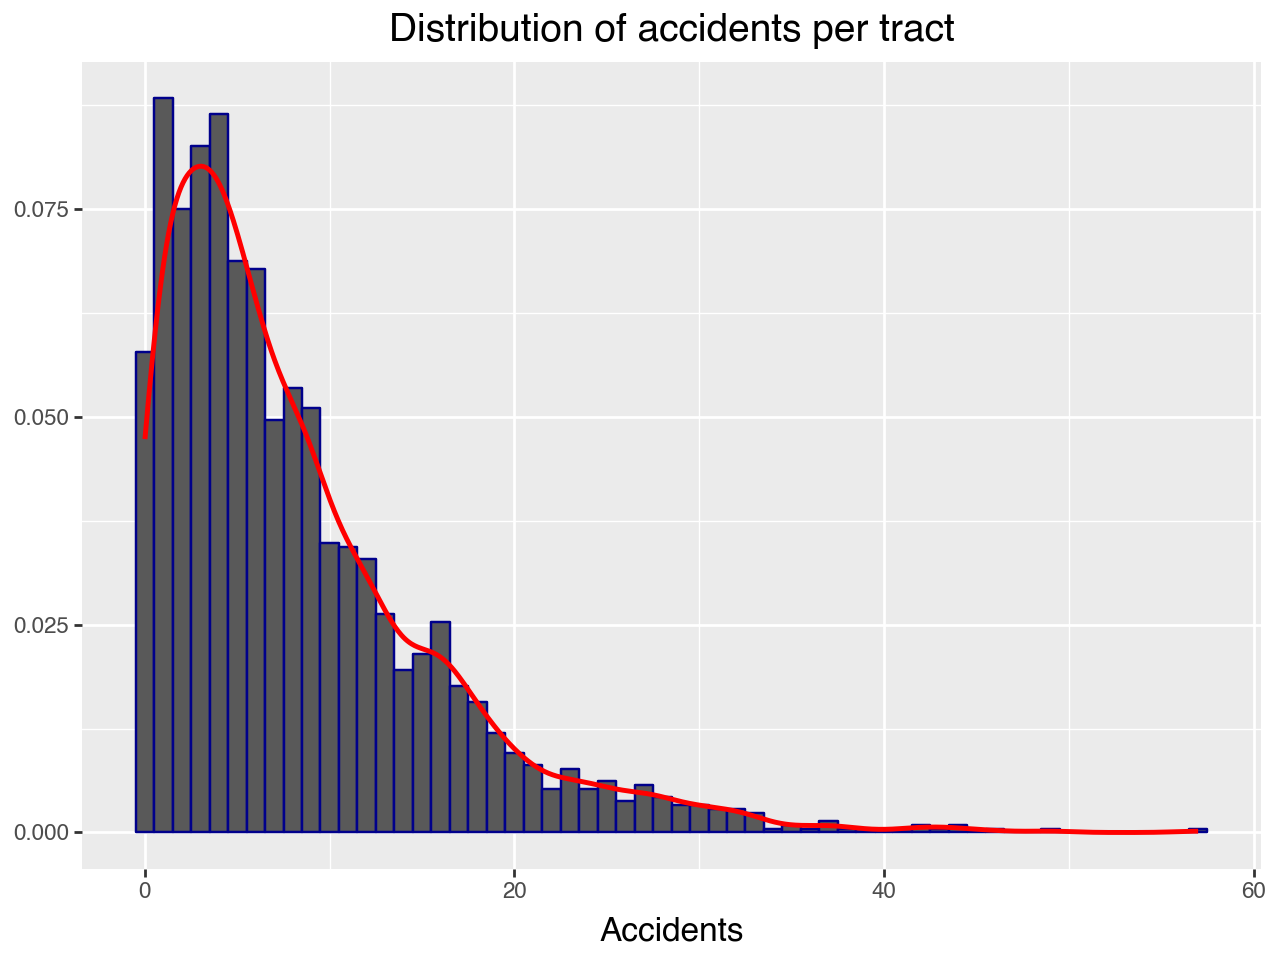

In [3]:
(
    p9.ggplot(data=nyc_geodata, mapping=p9.aes(x='count')) +
    p9.geom_histogram(p9.aes(y=p9.after_stat('density')), bins=58, color='DarkBlue') +
    p9.geom_density(color="red", size=1) +
    p9.ggtitle("Distribution of accidents per tract") +
    p9.xlab("Accidents") + p9.ylab("")
)

**R**
```{r}
ggplot(data = nyc_geodata, aes(x = count)) +
  geom_histogram(aes(y = after_stat(density)), bins = 58, color = 'DarkBlue', fill = "skyblue", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1) +
  ggtitle("Distribution of accidents per tract") +
  xlab("accidents") +
  ylab("")
```

### Visualize by Map Areas

#### Show areal map, fill color is accidents per tract

**Python**

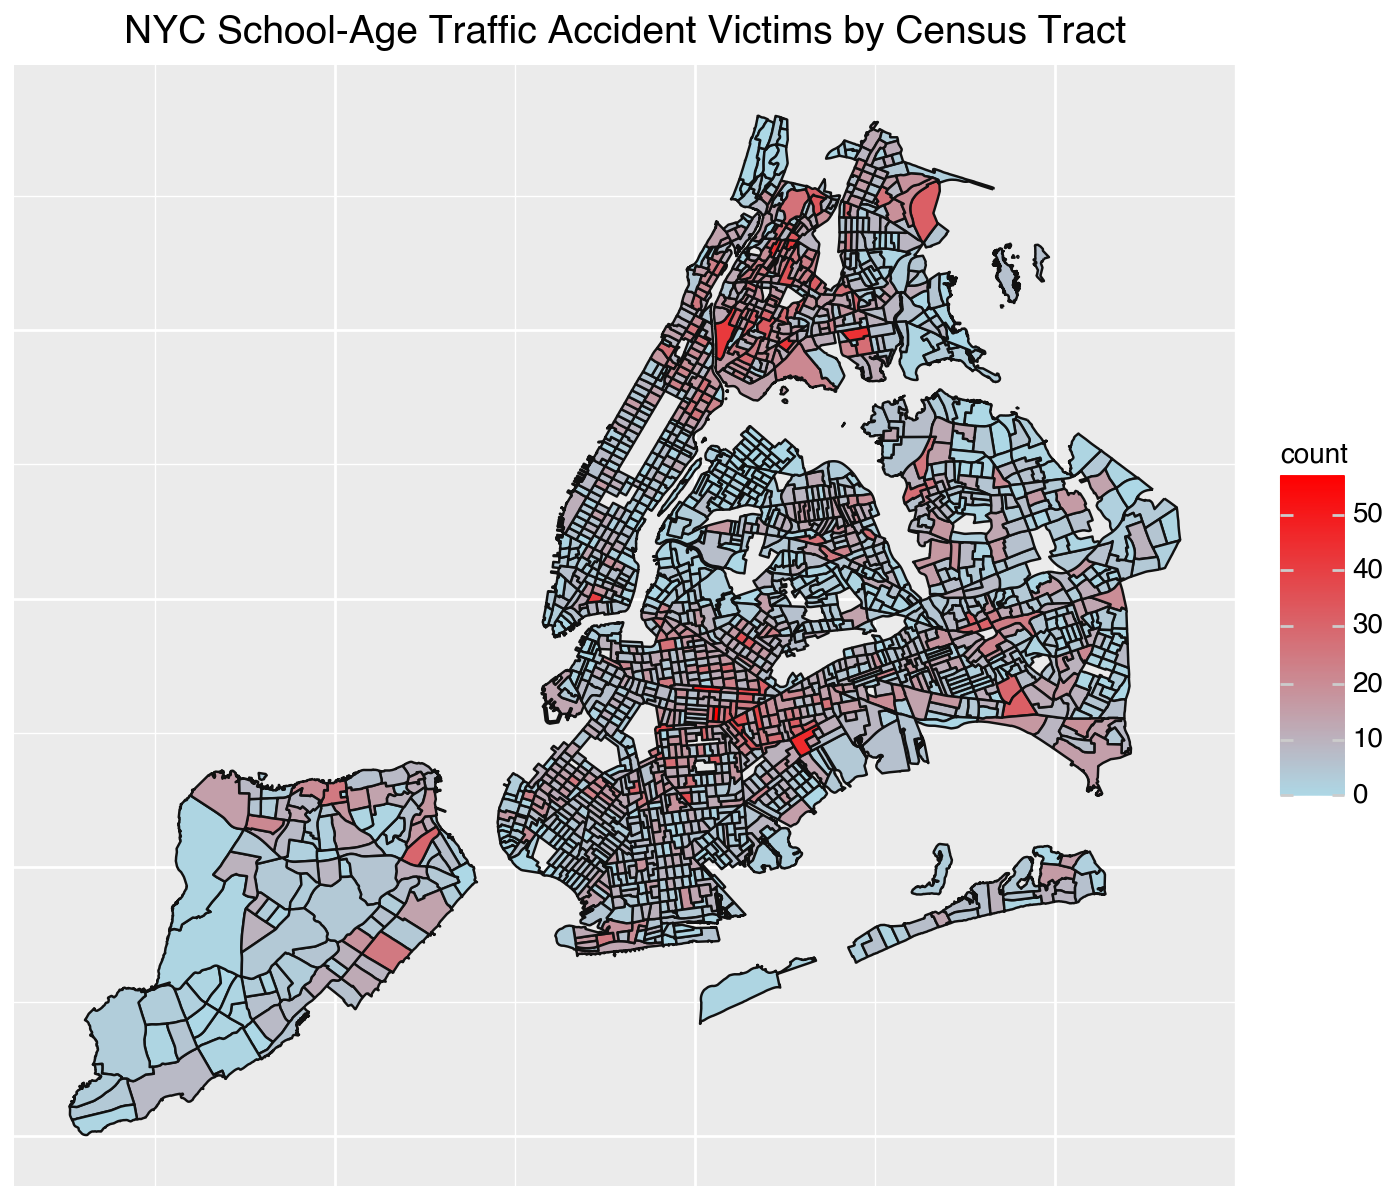

In [4]:
(
    p9.ggplot(nyc_geodata) +
    p9.geom_map(p9.aes(fill='count')) +
    p9.scale_fill_gradient(low="lightblue", high="red") +
    p9.labs(title="NYC School-Age Traffic Accident Victims by Census Tract") +
    map_theme
)

**R**
```{r}
ggplot(data = nyc_geodata) +
geom_sf(aes(fill = count)) +
scale_fill_gradient(low = "lightblue", high = "red") +
labs(title = "NYC School-Age Traffic Accident Victims by Census Tract")
```

#### Show areal map, fill color is kid population per tract

**Python**

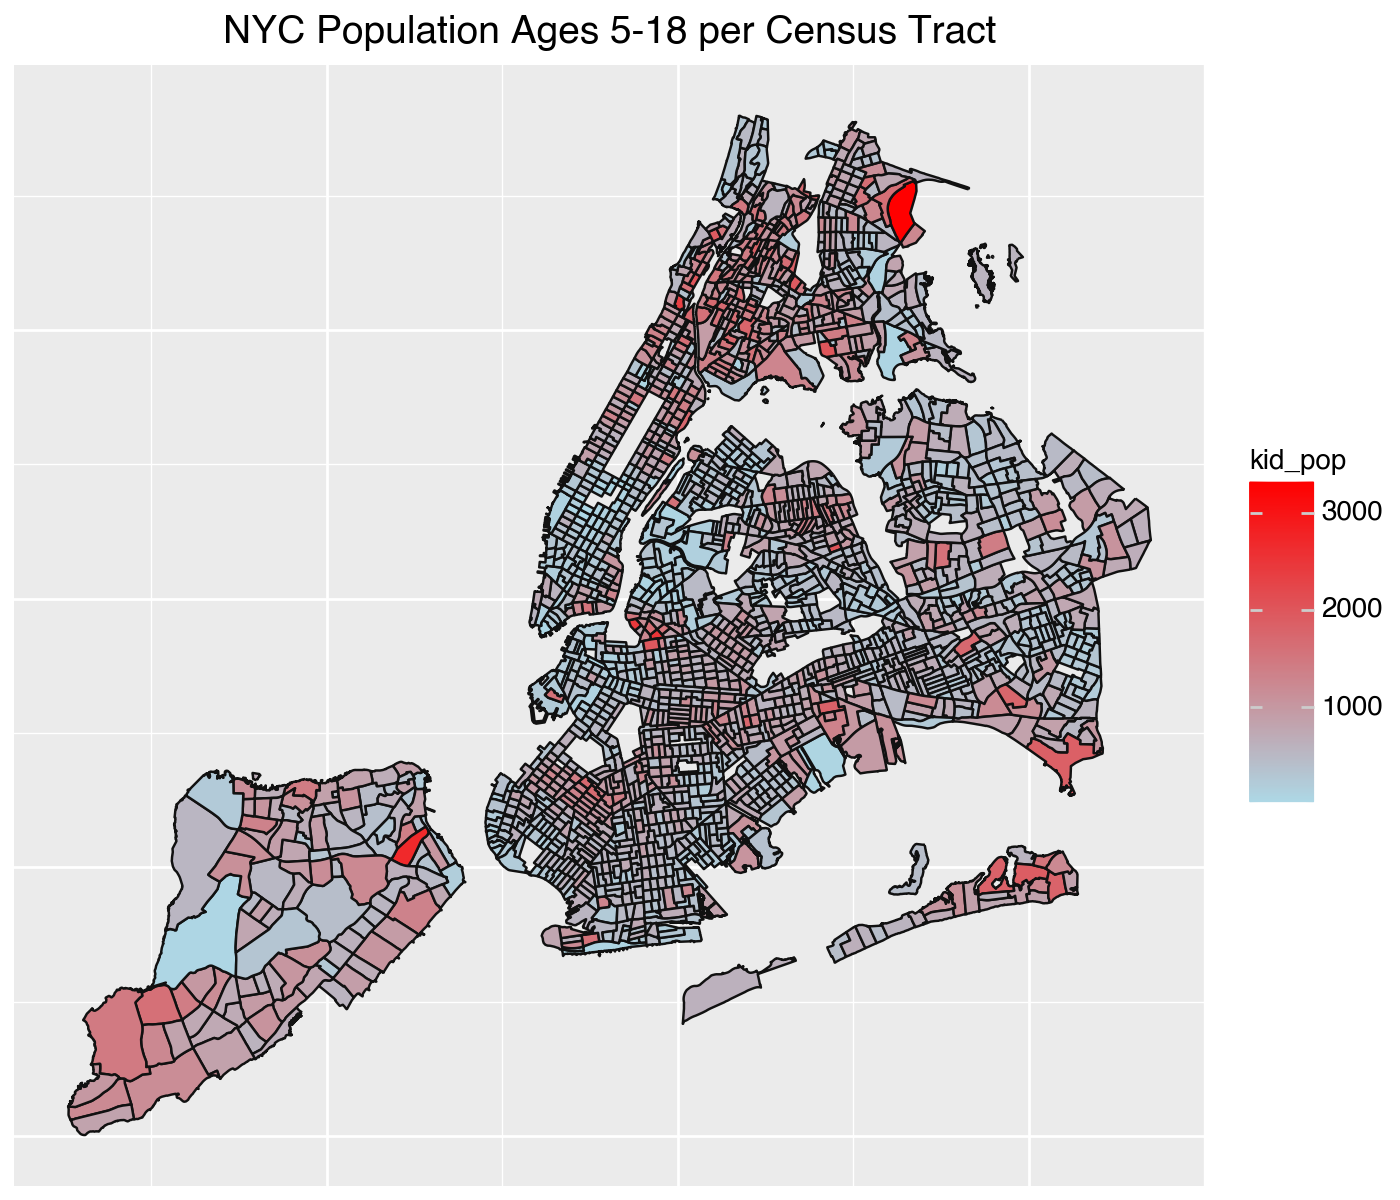

In [5]:
(
    p9.ggplot(nyc_geodata) +
    p9.geom_map(p9.aes(fill='kid_pop')) +
    p9.scale_fill_gradient(low="lightblue", high="red") +
    p9.labs(title = "NYC Population Ages 5-18 per Census Tract") +
    map_theme
)

**R**
```{r}
ggplot(data = nyc_geodata) +
    geom_sf(aes(fill = kid_pop)) +
    scale_fill_gradient(low = "lightblue", high = "red") +
    labs(title = "NYC Population Ages 5-18 Density by Census Tract")
```

#### Population: raw counts, density per square mile

**Python**

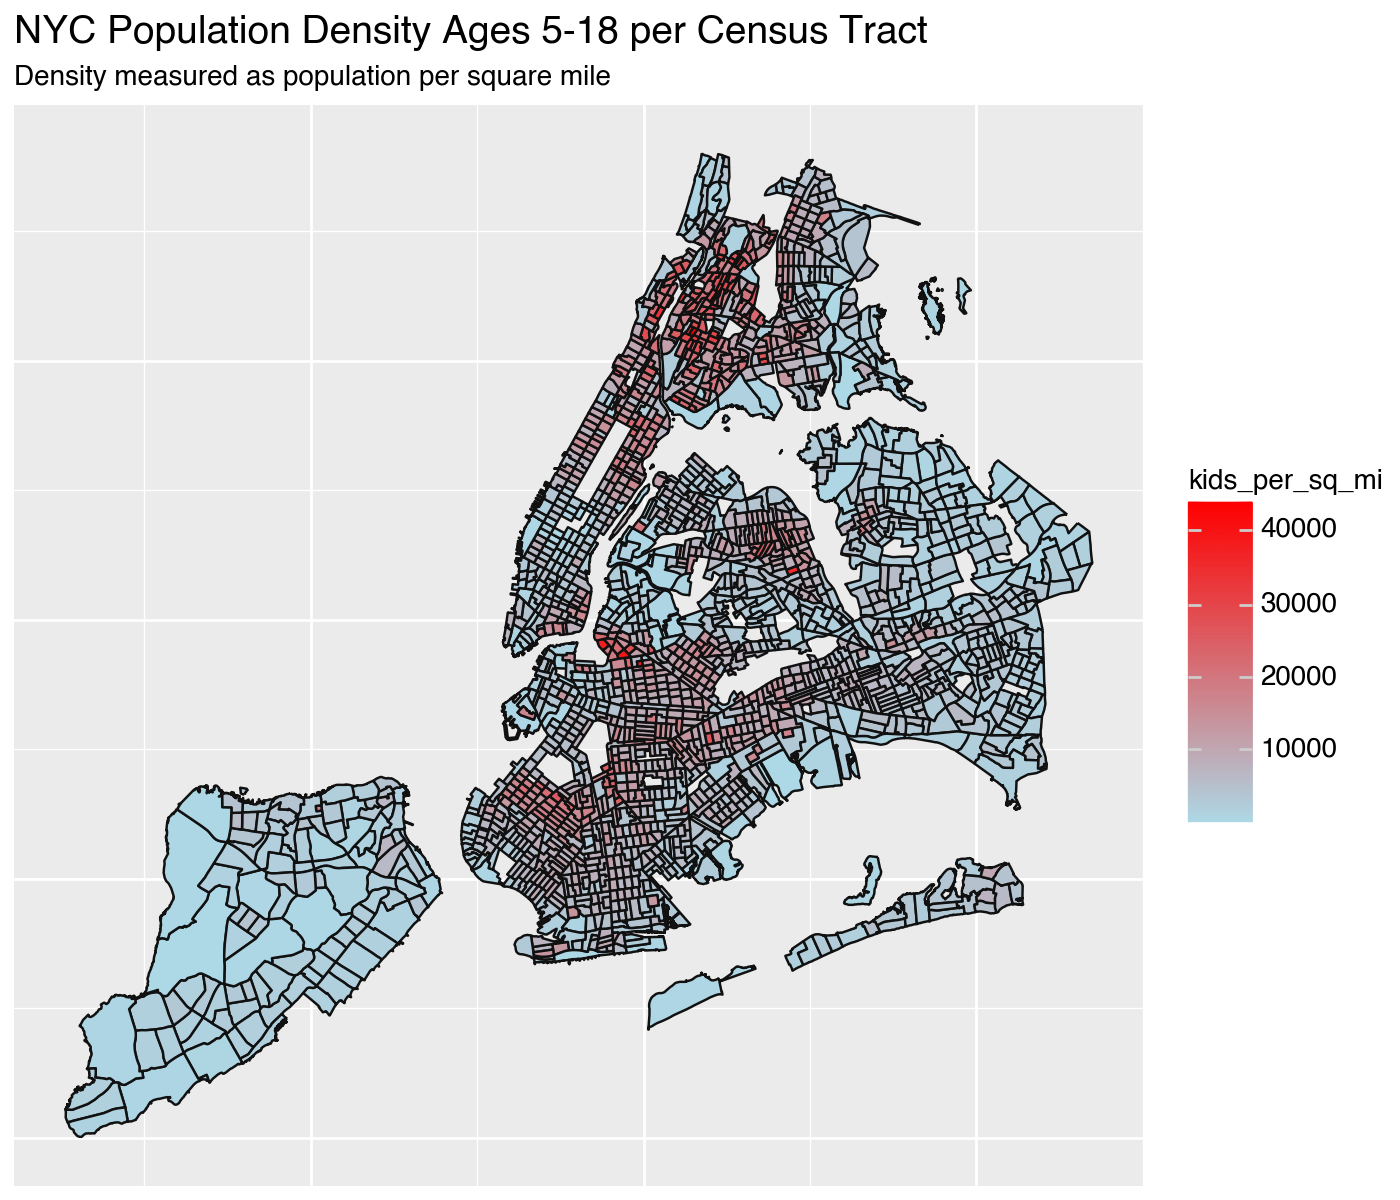

In [6]:
(
    p9.ggplot(nyc_geodata) +
    p9.geom_map(p9.aes(fill='kids_per_sq_mi')) +
    p9.scale_fill_gradient(low="lightblue", high="red") +
    p9.labs(title = "NYC Population Density Ages 5-18 per Census Tract",
         subtitle = "Density measured as population per square mile") +
    map_theme	 
)

**R**
```{r}
ggplot(data = nyc_geodata) +
    geom_sf(aes(fill = kids_per_sq_mi)) +
    scale_fill_gradient(low = "lightblue", high = "red") +
    labs(title = "NYC Population Ages 5-18 Density by Census Tract",
         subtitle = "Density measured as population per square mile")
```

##  Exercises

* Visualize `med_hh_inc` (median household income), `frag_index` (fragmentation index), and `traffic`.

* Create histograms of predictors `med_hh_inc`, `traffic`.   How can these be rescaled?

## Spatial Smoothing For Areal Data:  From Maps to Graphs

By defining a neighbor relationship between area regions, we convert a map to a graph.

- *Neighbor relation* defined in terms of shared boundaries

- Compute this autmatically from `nyc_geodata` spatial geometry component
  + R package `spdep`
  + Python package `libpysal`


### Alternative encodings of neighborhood graph

- $N \times N$ Adjacency matrix
  + Entries $(i,\ j)$ and $(j,\ i)$ are 1 when regions $n_i$ and $n_j$ are neighbors, 0 otherwise

- Undirected graph: regions are vertices, pairs of neighbors are edges
  + Encoded as *edges* - 2 column matrix, each row is a pair of neighbors $({n_i}, {n_j})$



#### Compute neighborhood graph


**Python: Computing the neighborhood network with libpysal**

We need to compute the adjacency network between the regions in our map.
We do this with [libpysal](https://pysal.org/libpysal/), a Python library for spatial analysis, which we have imported as `sa`.
To visualize this graph overlaid on the county map, we use [splot](https://splot.readthedocs.io/en/latest/), a lightweight visualization interface.

There are several ways to define the neighbor relationship, see https://pysal.org/libpysal/api.html#spatial-weights.
Here we use the *Rook* metric:  regions which share a common line boundary are neighbors.  This returns a spatial weights object, [weights.W](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal-weights-w)


In [73]:
w_nyc_nbs = sa.weights.Rook(nyc_geodata['geometry'])

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

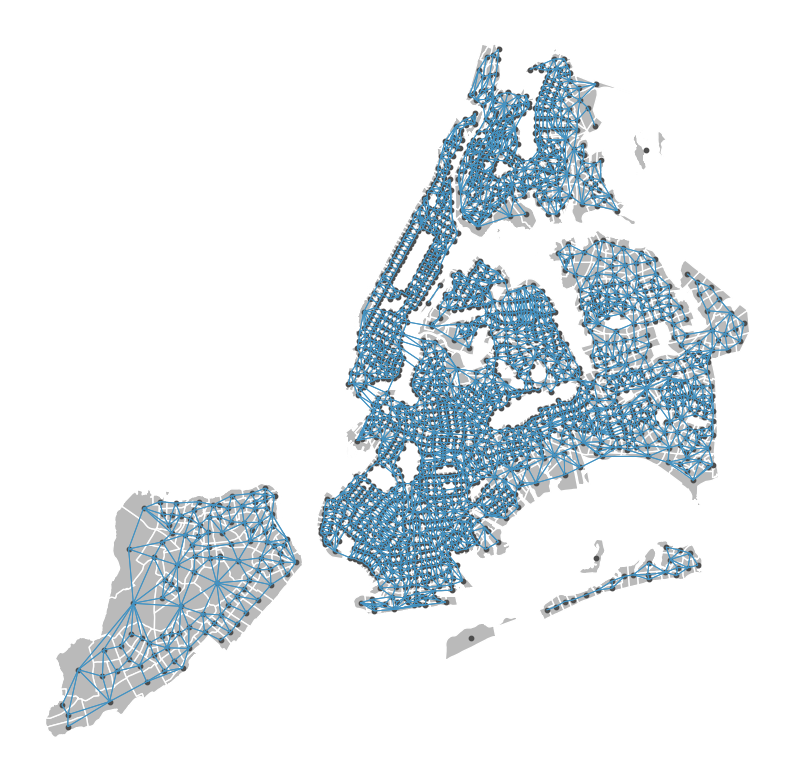

In [74]:
from splot.libpysal import plot_spatial_weights 
plot_spatial_weights(w_nyc_nbs, nyc_geodata) 

In [76]:
print(f'number of components: {w_nyc_nbs.n_components}')
print(f'islands? {w_nyc_nbs.islands}')
print(f'max nmber of neighbors per node: {w_nyc_nbs.max_neighbors}')
print(f'mean nmber of neighbors per node: {w_nyc_nbs.mean_neighbors}')
comp_ids = w_nyc_nbs.component_labels

number of components: 8
islands? [328, 1860, 1903]
max nmber of neighbors per node: 12
mean nmber of neighbors per node: 4.926968973747017


In [86]:
print(comp_ids.shape)
np.bincount(comp_ids)

(2095,)


array([ 329,    1, 1631,    2,    1,   22,    1,  108])

### Representing the neighborhood network as an adjacency list

We use the libpysal Weights object method [to_adjlist](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W.to_adjlist) to extract neighbor information in the form of a list of adjacent nodes.
All the indices are 0-based and match the order in which they occur in the GeoPandasDataFrame object `nyc_geodata`.

In [72]:
w_nyc_nbs_adj =  w_nyc_nbs.to_adjlist(remove_symmetric=True)
w_nyc_nbs_adj.head(10)

,focal,neighbor,weight
0,0,1,1.0
1,0,2,1.0
2,0,4,1.0
4,1,2,1.0
5,1,44,1.0
6,1,51,1.0
7,1,56,1.0
10,2,4,1.0
11,2,14,1.0
12,2,18,1.0


* Challenges:  amount of connectivity, allow islands?

* Especially pertinent for NYC (Staten Island) and UK (Northern Ireland)

* First version, fully connected. (*Keep it simple!*)

For the paper, we created a fully connected graph; we'll just use it for now.